In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import cv2

from time import time
from time import sleep
import re
import os

import argparse
from collections import OrderedDict

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage

import dlib

from tensorflow.keras.models import load_model
from imutils import face_utils

import requests
import multiprocessing
import pyaudio
import wave

# TODO: Do real-time recording then process it
from SpeechEmotionRecognition import speechEmotionRecognition
import time
from PIL import Image
import matplotlib.pyplot as plt


global shape_x
global shape_y
global input_shape
global nClasses

C:\Users\cecil\AppData\Roaming\Python\Python310\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def show_webcam(speech_recognizer) :
    # Create an instance of speechEmotionRecognition

    # Specify the filename for audio recording
    #audio_filename = "Recording.wav"

    # Record audio for a duration (e.g., 5 seconds)

    shape_x = 48
    shape_y = 48
    input_shape = (shape_x, shape_y, 1)
    nClasses = 7

    thresh = 0.25
    frame_check = 20
    audio_filename = "../Media/Recording.wav"

    def eye_aspect_ratio(eye):
        A = distance.euclidean(eye[1], eye[5])
        B = distance.euclidean(eye[2], eye[4])
        C = distance.euclidean(eye[0], eye[3])
        ear = (A + B) / (2.0 * C)
        return ear

    def detect_face(frame):
        
        #Cascade classifier pre-trained model
        cascPath = '../Model/face_landmarks.dat'
        faceCascade = cv2.CascadeClassifier(cascPath)
        
        #BGR -> Gray conversion
        if frame is not None:
            # Perform image processing operations on 'frame'
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            print("Error: The frame is empty or not properly loaded.")
        
        faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        #Cascade MultiScale classifier
        detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                      minSize=(shape_x, shape_y),
                                                      flags=cv2.CASCADE_SCALE_IMAGE)
        coord = []
                                                      
        for x, y, w, h in detected_faces :
            if w > 100 :
                sub_img=frame[y:y+h,x:x+w]
                cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 255,255),1)
                coord.append([x,y,w,h])

        return gray, detected_faces, coord

    def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
        gray = faces[0]
        detected_face = faces[1]
        
        new_face = []
        
        for det in detected_face :
            x, y, w, h = det
            
            #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
            horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
            vertical_offset = np.int(np.floor(offset_coefficients[1] * h))
            
            #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            #gray transforme l'image
            extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
            
            #Zoom sur la face extraite
            new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
            #cast type float
            new_extracted_face = new_extracted_face.astype(np.float32)
            #scale
            new_extracted_face /= float(new_extracted_face.max())
            #print(new_extracted_face)
            
            new_face.append(new_extracted_face)
        
        return new_face


    '''(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    
    (nStart, nEnd) = face_utils.FACIAL_LANDMARKS_IDXS["nose"]
    (mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
    (jStart, jEnd) = face_utils.FACIAL_LANDMARKS_IDXS["jaw"]

    (eblStart, eblEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
    (ebrStart, ebrEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]'''

    model = load_model('../Model/Xception.h5')
    #model = load_model('Xception/model/model_xception.keras')
    #model = load_model('Mini_Xception/model/_mini_xceptionmodel.hdf5')
    #model = load_model('Xception/Balanced/EmotionExpression_weights.hdf5')
    face_detect = dlib.get_frontal_face_detector()
    predictor_landmarks  = dlib.shape_predictor("../Model/face_landmarks.dat")
    i_table=[]
    prediction_table=[]
    timestamp_table=[]
    #Lancer la capture video
    video_capture = cv2.VideoCapture(0)
    exit_event = multiprocessing.Event()
    background_process = multiprocessing.Process(target=speech_recognizer.voice_recording_multi,args=(audio_filename,exit_event))
    background_process.start()
    start_time=(int(time.time()))
    while True:
        # Capture frame-by-frame
        ret, frame = video_capture.read()
        face_index = 0
        
        #BGR -> Gray conversion
        if frame is not None:
            # Perform image processing operations on 'frame'
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            print("Error: The frame is empty or not properly loaded.")
        rects = face_detect(gray, 1)
        num_rects = len(rects)
        
        # Print or use the length as needed
        print(f"The number of rectangles is: {num_rects}")

        for (i, rect) in enumerate(rects):

            shape = predictor_landmarks(gray, rect)
            shape = face_utils.shape_to_np(shape)
            
            # Identify face coordinates
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            face = gray[y:y+h,x:x+w]
            
            #Zoom on extracted face
            face = zoom(face, (shape_x / face.shape[0],shape_y / face.shape[1]))
            
            #Cast type float
            face = face.astype(np.float32)
            
            #Scale
            face /= float(face.max())
            face = np.reshape(face.flatten(), (1, 48, 48, 1))
            
            #Make Prediction
            prediction = model.predict(face)
            prediction_result = np.argmax(prediction)
            
            # Rectangle around the face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 0), 2)
        
            cv2.putText(frame, "Face #{}".format(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 2)
     
            for (j, k) in shape:
                cv2.circle(frame, (j, k), 1, (0, 0, 255), -1)
            #frame_height, frame_width = frame.shape[:2]
            #x = frame_width - 200  # Adjust the value as needed for horizontal spacing

            if num_rects>1:
                # 1. Add prediction probabilities
                cv2.putText(frame, "*****************",(40,110 + 45*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 0)
                cv2.putText(frame, "Facial Expression report : Face #" + str(i+1),(40,120 + 45*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 0)
                
                
                # 2. Annotate main image with a label
                print(prediction_result)
                if prediction_result == 0 :
                    cv2.putText(frame, "Angry : " + str(round(prediction[0][0],3)),(40,140 + 45*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 0)
                    cv2.putText(frame, "Angry",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Angry")
                    timestamp_table.append(int(time.time())-start_time)
                elif prediction_result == 1 :
                    cv2.putText(frame, "Disgust : " + str(round(prediction[0][1],3)),(40,140 + 45*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 0)
                    cv2.putText(frame, "Disgust",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Disgust")
                    timestamp_table.append(int(time.time())-start_time)
                elif prediction_result == 2 :
                    cv2.putText(frame, "Fear : " + str(round(prediction[0][2],3)),(40,140 + 45*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1)
                    cv2.putText(frame, "Fear",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Fear")
                    timestamp_table.append(int(time.time())-start_time)
                elif prediction_result == 3 :
                    cv2.putText(frame, "Happy : " + str(round(prediction[0][3],3)),(40,140 + 45*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1)
                    cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Happy")
                    timestamp_table.append(int(time.time())-start_time)
                elif prediction_result == 4 :
                    cv2.putText(frame, "Sad : " + str(round(prediction[0][4],3)),(40,140 + 45*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1)
                    cv2.putText(frame, "Sad",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Sad")
                    timestamp_table.append(int(time.time())-start_time)
                elif prediction_result == 5 :
                    cv2.putText(frame, "Surprise : " + str(round(prediction[0][5],3)),(40,140 + 45*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1)
                    cv2.putText(frame, "Surprise",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1,(255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Surprise")
                    timestamp_table.append(int(time.time())-start_time)
                else :
                    cv2.putText(frame, "Neutral : " + str(round(prediction[0][6],3)),(40,140 + 45*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1)
                    cv2.putText(frame, "Neutral",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1,(255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Neutral")
                    timestamp_table.append(int(time.time())-start_time)

            else:
                
                # 1. Add prediction probabilities
                cv2.putText(frame, "*****************",(40,100 + 180*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 0)
                cv2.putText(frame, "Facial Expression report : Face #" + str(i+1),(40,120 + 180*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 0)
                cv2.putText(frame, "Angry : " + str(round(prediction[0][0],3)),(40,140 + 180*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 0)
                cv2.putText(frame, "Disgust : " + str(round(prediction[0][1],3)),(40,160 + 180*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 0)
                cv2.putText(frame, "Fear : " + str(round(prediction[0][2],3)),(40,180 + 180*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1)
                cv2.putText(frame, "Happy : " + str(round(prediction[0][3],3)),(40,200 + 180*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1)
                cv2.putText(frame, "Sad : " + str(round(prediction[0][4],3)),(40,220 + 180*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1)
                cv2.putText(frame, "Surprise : " + str(round(prediction[0][5],3)),(40,240 + 180*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1)
                cv2.putText(frame, "Neutral : " + str(round(prediction[0][6],3)),(40,260 + 180*i), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1)
                
                
                # 2. Annotate main image with a label
                print(prediction_result)
                if prediction_result == 0 :
                    cv2.putText(frame, "Angry",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Angry")
                    timestamp_table.append(int(time.time())-start_time)
                elif prediction_result == 1 :
                    cv2.putText(frame, "Disgust",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Disgust")
                    timestamp_table.append(int(time.time())-start_time)
                elif prediction_result == 2 :
                    cv2.putText(frame, "Fear",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Fear")
                    timestamp_table.append(int(time.time())-start_time)
                elif prediction_result == 3 :
                    cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Happy")
                    timestamp_table.append(int(time.time())-start_time)
                elif prediction_result == 4 :
                    cv2.putText(frame, "Sad",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1, (255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Sad")
                    timestamp_table.append(int(time.time())-start_time)
                elif prediction_result == 5 :
                    cv2.putText(frame, "Surprise",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1,(255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Surprise")
                    timestamp_table.append(int(time.time())-start_time)
                else :
                    cv2.putText(frame, "Neutral",(x+w-10,y-10), cv2.FONT_HERSHEY_DUPLEX, 1,(255,0,0), 2)
                    i_table.append(i)
                    prediction_table.append("Neutral")
                    timestamp_table.append(int(time.time())-start_time)
                
            
            '''
            # 3. Eye Detection and Blink Count
            leftEye = shape[lStart:lEnd]
            rightEye = shape[rStart:rEnd]
            
            # Compute Eye Aspect Ratio
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)
            ear = (leftEAR + rightEAR) / 2.0
            
            # And plot its contours
            leftEyeHull = cv2.convexHull(leftEye)
            rightEyeHull = cv2.convexHull(rightEye)
            cv2.drawContours(frame, [leftEyeHull], -1, (255, 0, 0), 1)
            cv2.drawContours(frame, [rightEyeHull], -1, (255, 0, 0), 1)
            
            # 4. Detect Nose
            nose = shape[nStart:nEnd]
            noseHull = cv2.convexHull(nose)
            cv2.drawContours(frame, [noseHull], -1, (255, 0, 0), 1)

            # 5. Detect Mouth
            mouth = shape[mStart:mEnd]
            mouthHull = cv2.convexHull(mouth)
            cv2.drawContours(frame, [mouthHull], -1, (255, 0, 0), 1)
            
            # 6. Detect Jaw
            jaw = shape[jStart:jEnd]
            jawHull = cv2.convexHull(jaw)
            cv2.drawContours(frame, [jawHull], -1, (255, 0, 0), 1)
            
            # 7. Detect Eyebrows
            ebr = shape[ebrStart:ebrEnd]
            ebrHull = cv2.convexHull(ebr)
            cv2.drawContours(frame, [ebrHull], -1, (255, 0, 0), 1)
            ebl = shape[eblStart:eblEnd]
            eblHull = cv2.convexHull(ebl)
            cv2.drawContours(frame, [eblHull], -1, (255, 0, 0), 1)
            '''
        
        cv2.putText(frame,'Quantity of Facial Appearances : ' + str(len(rects)),(40, 40), cv2.FONT_HERSHEY_DUPLEX, 1, 155, 1)
        cv2.imshow('FacialExpressionDetection', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q') :
            break
    exit_event.set()
    background_process.join()
    # When everything is done, release the capture
    video_capture.release()
    cv2.destroyAllWindows()
    return i_table,prediction_table,timestamp_table


In [3]:
def visual_prediction_to_csv(predictions,timestamps,faceids,filename="../Out/predicted_visual_emotions.csv", mode='w'):
        # Write emotion in filename
        with open(filename, mode) as f:
            if mode == 'w':
                f.write("FaceID, TimeStamp, Emotion"+'\n')
            i=0
            for emotion in predictions:
                f.write(str(faceids[i])+","+str(timestamps[i])+","+str(emotion)+'\n')
                i+=1
            f.close()

In [4]:
import csv
from collections import defaultdict

def combine_results(file1,file2):
    # Read the first CSV file and store data in a dictionary
    file1_data = defaultdict(list)
    with open(file1, 'r') as file1:
        reader = csv.reader(file1)
        next(reader)  # Skip the header row
        for row in reader:
            timestamp, emotion = float(row[0]), row[1]
            file1_data[timestamp].append(emotion)

    # Read the second CSV file and store data in a dictionary
    file2_data = defaultdict(list)
    with open(file2, 'r') as file2:
        reader = csv.reader(file2)
        next(reader)  # Skip the header row
        for row in reader:
            timestamp, emotion = float(row[1]), row[2]
            file2_data[timestamp].append(emotion)

    # Create a new dictionary to store the combined emotions
    combined_data = defaultdict(lambda: [defaultdict(int), defaultdict(int)])

    # Calculate average emotions for the same timestamps
    for timestamp in set(file1_data.keys()).union(set(file2_data.keys())):
        for emotion in file1_data.get(timestamp, []):
            combined_data[timestamp][0][emotion] += 1
        for emotion in file2_data.get(timestamp, []):
            combined_data[timestamp][1][emotion] += 1

    # Write the combined data to a new CSV file
    with open('../Out/combined_emotions.csv', 'w', newline='') as combined_file:
        writer = csv.writer(combined_file)
        writer.writerow(["Timestamp", "Emotion (Audio)", "Emotion (Visual)"])
        for timestamp, emotions in combined_data.items():
            visual_emotion = max(emotions[0], key=emotions[0].get, default="Neutral")
            audio_emotion = max(emotions[1], key=emotions[1].get, default="Neutral")
            writer.writerow([timestamp, visual_emotion, audio_emotion])

In [5]:
def main():
    speech_recognizer = speechEmotionRecognition()
    audio_filename = "../Media/Recording.wav"
    
    i_table,prediction_table,timestamp_table=show_webcam(speech_recognizer)
    visual_prediction_to_csv(prediction_table,timestamp_table,i_table,filename="../Out/predicted_visual_emotions.csv", mode='w')
    emotions, timestamps = speech_recognizer.predict_emotion_from_file(audio_filename, predict_proba=False)
    #Print the predicted emotions and their timestamps
    for emotion, timestamp in zip(emotions, timestamps):
        print(f"Speech Emotion: {emotion}, Timestamp: {timestamp} seconds")
    speech_recognizer.prediction_to_csv(emotions,timestamps, "../Out/predicted_audio_emotions.csv", mode='w')
    combine_results("../Out/predicted_audio_emotions.csv",'../Out/predicted_visual_emotions.csv')

In [6]:
from IPython.display import display, clear_output
# Speak Continously so that Audio recognizer can evaluate without empty buffers.

if __name__ == "__main__":
    main()
    




The number of rectangles is: 1
1/1 [==============================] - 1s 1s/step
6
The number of rectangles is: 1
1/1 [==============================] - 0s 81ms/step
4
The number of rectangles is: 1
1/1 [==============================] - 0s 75ms/step
0
The number of rectangles is: 1
1/1 [==============================] - 0s 79ms/step
0
The number of rectangles is: 1
1/1 [==============================] - 0s 73ms/step
5
The number of rectangles is: 1
1/1 [==============================] - 0s 65ms/step
5
The number of rectangles is: 1
1/1 [==============================] - 0s 84ms/step
5
The number of rectangles is: 1
1/1 [==============================] - 0s 64ms/step
5
The number of rectangles is: 1
1/1 [==============================] - 0s 84ms/step
5
The number of rectangles is: 1
1/1 [==============================] - 0s 102ms/step
5
The number of rectangles is: 1
1/1 [==============================] - 0s 91ms/step
5
The number of rectangles is: 1
1/1 [===========================

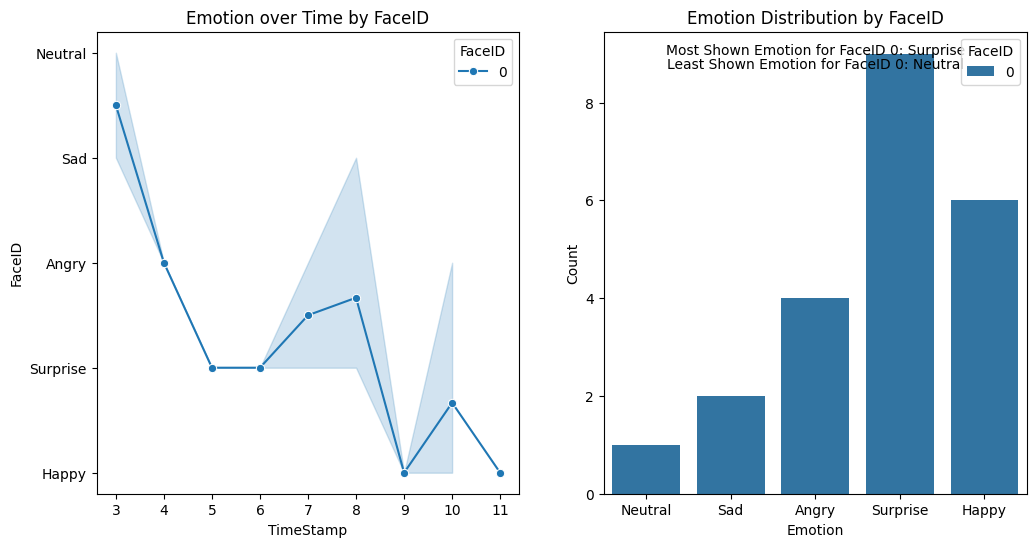

In [7]:
from SummarizeSingleModeEmotion import visualize_emotions
visualize_emotions("../Out/predicted_visual_emotions.csv")